# Load libraries 
for image processing we use skimage, for saving results pandas

In [38]:
%matplotlib inline

#ncore = 8

#import os
#os.environ['KMP_AFFINITY'] = 'disabled'
#os.environ['MKL_NUM_THREADS'] = str(ncore)

import numpy as np
import pandas as pd
from skimage.io import imread, imsave
from glob import glob
import matplotlib.pyplot as plt
from time import time

# Read in data
in this case a 3D tif stack of tomographic slices

In [2]:
# Set the data path
site_data_dir = '/data/staff/tomograms' # tomograms test data at MAX IV
#site_data_dir = '/projects/maxiv/staff/tomograms/test-data/' # tomograms test data at LUNARC

print("Site data root directory: %s" % site_data_dir)

Site data root directory: /data/staff/tomograms


In [3]:
!ls {site_data_dir}/test-data/imquant -lh

total 8.3G
-rw-rw-r-- 1 zdemat acc-tomograms-staff 2.8G Jul 14  2019 sample1_mid_0h_stack.tif
-rw-rw-r-- 1 zdemat acc-tomograms-staff 2.8G Jul 14  2019 sample1_mid_1h_stack.tif
-rw-rw-r-- 1 zdemat acc-tomograms-staff 2.8G Jul 14  2019 sample1_mid_2h_stack.tif


In [4]:
all_files = sorted(glob(site_data_dir+'/test-data/imquant/sample1_mid*stack.tif'))
print(len(all_files), all_files[0])
print(len(all_files), all_files[1])

3 /data/staff/tomograms/test-data/imquant/sample1_mid_0h_stack.tif
3 /data/staff/tomograms/test-data/imquant/sample1_mid_1h_stack.tif


In [5]:
stack_image = imread(all_files[1])

In [6]:
nhight, ncols, nrows = stack_image.shape
row, col = np.ogrid[:nrows, :ncols]
print(stack_image.shape, stack_image.dtype)

(1152, 1600, 1600) uint8


## (Optional) image-stack crop

Running this notebook on the full stack of example images may require large (~ 100 GB)
amount of memmory. You can downscale this requirements by working on smaller dataset.

In [7]:
# (optional) crop image stack

crop_imstack = True

if crop_imstack:
    stack_image = stack_image[:nhight//4,:,:]
    print('Cropped image-stack:')
    nhight, ncols, nrows = stack_image.shape
    row, col = np.ogrid[:nrows, :ncols]
    print(stack_image.shape, stack_image.dtype)

Cropped image-stack:
(288, 1600, 1600) uint8


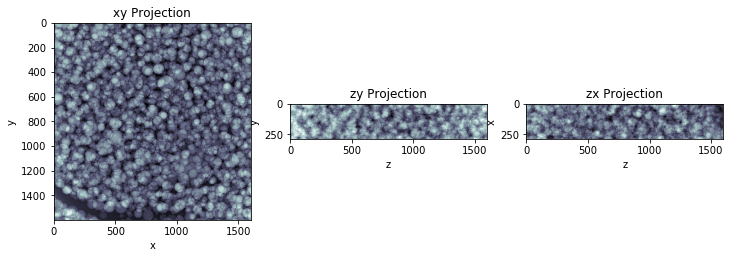

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12, 4))
for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
    cax.imshow(np.sum(stack_image,i).squeeze(), interpolation='none', cmap = 'bone_r')
    cax.set_title('%s Projection' % clabel)
    cax.set_xlabel(clabel[0])
    cax.set_ylabel(clabel[1])

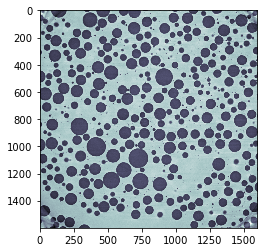

In [9]:
plt.imshow(stack_image[100],cmap='bone')

# Binarization

First remove extreme values from the image

In [10]:
# note: there is a slower alternative in scipy.stats
vmin, vmax = np.percentile(stack_image, (0.5, 99.5))

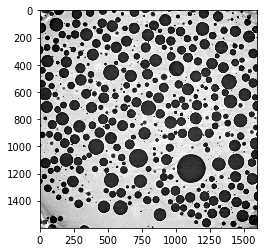

In [11]:
np.clip(stack_image, vmin, vmax, out=stack_image)
stack_image = (stack_image - np.float32(vmin)) / np.float32(vmax - vmin)
plt.imshow(stack_image[60], cmap='gray')

## Simple thresholding

In [12]:
from skimage import exposure
hi_stack_image = exposure.histogram(stack_image)

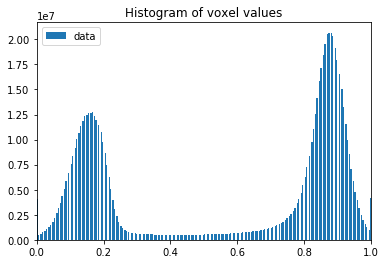

In [13]:
plt.bar(hi_stack_image[1],hi_stack_image[0],width=hi_stack_image[1][1]-hi_stack_image[1][0],label='data')
plt.xlim(0, 1)
plt.legend()
plt.title('Histogram of voxel values');

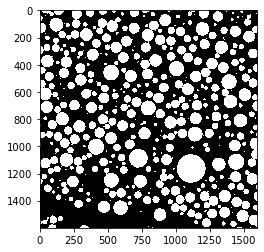

In [14]:
seg_stack_image = stack_image > 0.4
seg_stack_image_inv = np.invert(seg_stack_image)
plt.imshow(seg_stack_image_inv[60],cmap='gray')

## Random walker segmentation

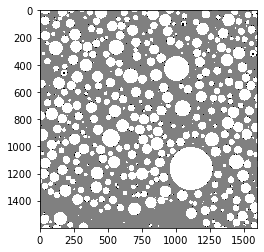

In [15]:
markers = np.zeros(stack_image.shape, dtype=np.uint8)
markers[stack_image > 0.4] = 1
markers[stack_image < 0.33] = 2
plt.imshow(markers[10], cmap='gray')

### Slab selection

Implementation of the random walker segmentation in scikit-image (0.14) requires
enourmous amount of memmory for large image datasets. So even image stack has been
already cropped above the Random-walker segmentation is demonstrated here only
on the slab of images of $2 x \text{slab_halfheight}$ selected from the middle of thr image stack.

In [16]:
# selcet a slab from the stack of images
sh = stack_image.shape
slab_halfheight = 16
stack_image_slab = stack_image[sh[0]//2-slab_halfheight:sh[0]//2+slab_halfheight,:,:] # slab
markers_slab = markers[sh[0]//2-slab_halfheight:sh[0]//2+slab_halfheight,:,:]

In [17]:
from skimage import segmentation

rw_slab = segmentation.random_walker(stack_image_slab, markers_slab, beta=1000., mode='cg_mg')

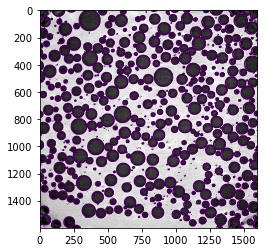

In [18]:
plt.imshow(stack_image_slab[10], cmap='gray')
plt.contour(rw_slab[10], [1.5])

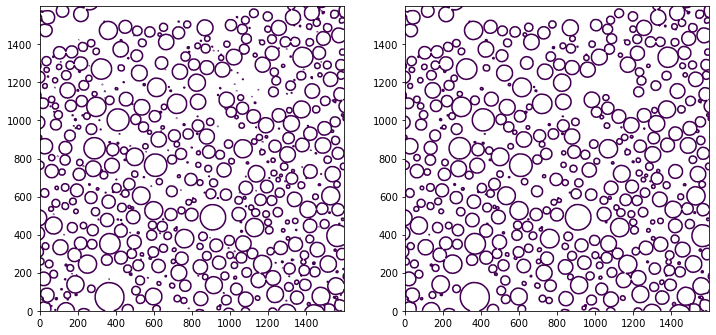

In [19]:
from skimage import morphology

clean_segmentation_slab = morphology.remove_small_objects(rw_slab == 2, 1000) # origin: 1, 200

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    fig, axs = plt.subplots(1,2,figsize=(12,6))
    axs[0].contour(rw_slab[10], [1.5])
    axs[0].axis('image');
    axs[1].contour(clean_segmentation_slab[10], [1.5])
    axs[1].axis('image');

# Create Bubble Image
The bubble image is the reverse of the plateau border image (where there is water there can't be air) with a convex hull used to find the mask of the image
$$ \text{Bubbles} = \text{ConvexHull}(\text{PlateauBorder}) - \text{PlateauBorder} $$

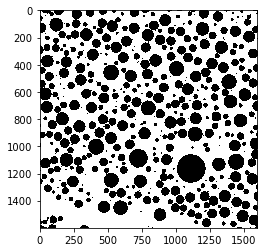

In [20]:
from skimage.morphology import binary_opening, convex_hull_image as chull
bubble_image = np.stack([chull(csl>0) & (csl==0) for csl in seg_stack_image_inv])
plt.imshow(bubble_image[60]>0, cmap = 'bone')

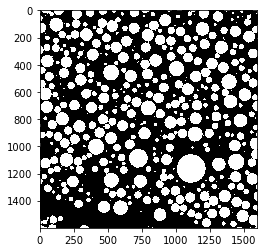

In [21]:
bubble_invert=np.invert(bubble_image)
plt.imshow(bubble_invert[60],cmap='bone')

# Save binary image

In [22]:
# note: tiffile will not be able to write binary data
seg_stack_imageS = seg_stack_image[100,300:600,300:600].astype(np.uint8)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    imsave(fname='sample1_binary.tif', arr=seg_stack_imageS, plugin='tifffile', bigtiff=True, compress=6)

## Save intemediate results in numpy format

Let's save main results (i.e. _seg_stack_image_inv_ and _bubble_invert_) from the previous cells here
in a native numpy format. Notebook can reload from this point in case by reverting the logic.

In [23]:
save_intermediate = True

if save_intermediate:
    np.save('seg_stack_image_inv.npy', seg_stack_image_inv)
    np.save('bubble_invert.npy', bubble_invert)
    np.save('stack_image.npy', stack_image)
else:
    seg_stack_image_inv = np.load('seg_stack_image_inv.npy') #[:100,:,:]
    bubble_invert = np.load('bubble_invert.npy') #[:100,:,:]
    stack_image = np.load('stack_image.npy') #[:100,:,:]

# create distance map

In [24]:
from scipy import ndimage as ndi

#from scipy.ndimage.morphology import distance_transform_edt as distmap # slow, requires lot of MEM
from edt import edt as distmap # fast, precise enough, good MEM requirements

bubble_dist = distmap(seg_stack_image_inv)
#bubble_dist = distmap(bubble_invert)

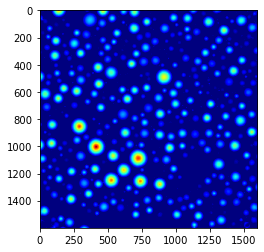

In [25]:
plt.imshow(bubble_dist[100,:,:],interpolation='none',cmap='jet')

# Calculate local maxima

In [26]:
from skimage.feature import peak_local_max
bubble_candidates=peak_local_max(bubble_dist,min_distance=12)
print('Found',len(bubble_candidates),'bubbles')

Found 8876 bubbles


In [27]:
df = pd.DataFrame(data=bubble_candidates, columns=['x','y','z'])
df.to_csv('./bubble.candidates_sample1_mid.csv')

# Watershed segmentation

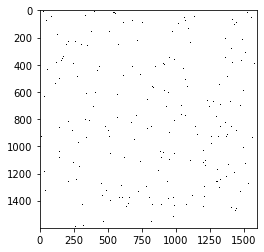

In [28]:
from skimage.morphology import watershed
bubble_seeds=peak_local_max(bubble_dist,min_distance=10, indices='false')
plt.imshow(np.any(bubble_seeds,0).squeeze(),interpolation='none', cmap='bone_r')

In [29]:
markers = ndi.label(bubble_seeds)[0]
#cropped_markers = markers[50:450,50:450,50:450]
#cropped_bubble_dist=bubble_dist[50:450,50:450,50:450]
#cropped_bubble_inver=bubble_invert[50:450,50:450,50:450]
#labeled_bubbles= watershed(-bubble_dist, markers, mask=bubble_invert)
labeled_bubbles= watershed(-bubble_dist, markers, mask=seg_stack_image_inv)

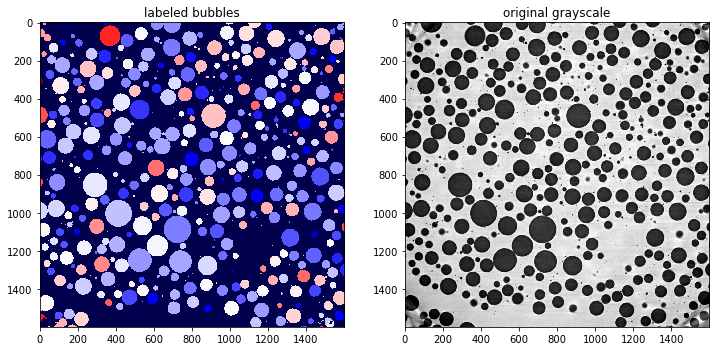

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.set_title('labeled bubbles')
ax1.imshow(labeled_bubbles[100,:,:], cmap=plt.cm.seismic, interpolation='nearest')
ax2.set_title('original grayscale')
ax2.imshow(stack_image[100,:,:], cmap='gray')

# Feature properties

In [35]:
from skimage.measure import regionprops
regions=regionprops(labeled_bubbles)
regions[40].filled_area
regions[40].centroid

(29.41234782133439, 939.6380381761788, 519.7602893956577)

# Save labeled image and properties

In [40]:
#from tifffile import imsave
#image = np.zeros((32, 256, 256), 'uint16')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    imsave('sample1_mid_labeled.tif', labeled_bubbles) 

In [42]:
#bubble volumes
bubble_volume=[prop.filled_area for prop in regions]
bubble_volume_mean=np.mean(bubble_volume)
dfV = pd.DataFrame(data=bubble_volume, columns=['volume [pix^3]'])
dfV.to_csv('./bubble_volumes_sample1_mid.csv')
Vm = {'mean volume': [1,bubble_volume_mean]}
dfVm=pd.DataFrame(data=Vm)

#liquid fraction
vols_image=nhight*ncols*nrows
vols_allbubbles=sum(bubble_volume)
liquid_fraction=1-vols_allbubbles/vols_image
print('liquid fraction = ',liquid_fraction)
LFcol = {'liquid fraction': [1,liquid_fraction]}
dfLF=pd.DataFrame(data=LFcol)

#BUBBLE Diameters
bubble_diameter=[prop.equivalent_diameter for prop in regions]
bubble_diameter_mean=np.mean(bubble_diameter)
print('mean bubble diameter [pixels] = ', bubble_diameter_mean)
dfD = pd.DataFrame(data=bubble_diameter, columns=['diameter [pix]'])
dfD.to_csv('./bubble_diameters_sample1_mid.csv')
Dm = {'mean diameter': [1,bubble_diameter_mean]}
dfDm=pd.DataFrame(data=Dm)

#BUBBLE CENTERS
bubble_centers=[prop.centroid for prop in regions]
#bubble_centers[1]
#all_properties = {'x': bubble_centers, 'volume' : bubble_volumes}
dfC = pd.DataFrame(data=bubble_centers, columns=['posX','posY','posZ'])
dfC.to_csv('./bubble_centroid_sample1_mid.csv')

liquid fraction =  0.6252681260850694
mean bubble diameter [pixels] =  18.67392008772659


In [43]:
dfA = pd.concat([dfLF.round(2),dfV,dfVm.round(0),dfD.round(0),dfDm.round(0),dfC.round(0)], axis=1, join='outer', ignore_index=False)
dfA.to_csv('./bubble_props_sample1_mid.csv')
#columns = ["volume","diameter"] #a csv with 3 columns
#index = [i[0] for i in all_properties] #first element of every list in yourlist
#not_index_list = [i[1:] for i in all_properties]
#df = pd.DataFrame(not_index_list, columns = columns, index = index)
#Now you have a csv with columns and index:
#df.to_csv('./bubble_props_sample1_mid.csv')

Text(0.5, 1.0, 'radii  distribution')

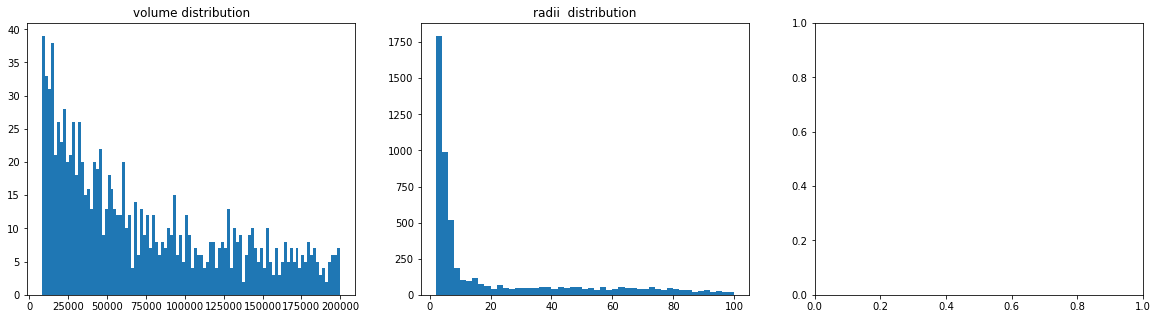

In [44]:
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(20,5))
ax1.hist(bubble_volume, bins=100, range = [8000,200000] )
ax1.set_title('volume distribution')
ax2.hist(bubble_diameter, np.linspace(2, 100, 50), label = 's1_mid_t0')
ax2.set_title('radii  distribution')

In [45]:
vols = []
all_radii = []
for props in regions:    
    #vols = props.filled_area + vols
    vols += [props.filled_area]
    all_radii += [props.equivalent_diameter]
#df = pd.DataFrame(data=regions.filled_area, columns=['label','volume'] )
#df.to_csv('./bubble_volumes_sample1_mid.csv')

In [48]:
from skimage.measure import marching_cubes_lewiner
from mayavi import mlab
#verts, faces, normals, values = marching_cubes_lewiner(bubble_invert, 0.0) 
mlab.triangular_mesh([vert[0] for vert in verts], [vert[1] for vert in verts],[vert[2] for vert in verts],faces)
mlab.show()

RuntimeError: No traitsui.toolkits plugin found for toolkit null